# Projekt zaliczeniowy - Przetwarzanie obrazów cyfrowych
Autor: **Patryk Ciepiela**

In [1]:
# Ładowanie bibliotek

import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, exposure, morphology, io, img_as_ubyte
from skimage.color import rgb2gray
import cv2
import warnings
import time

In [2]:
COLOR_FOREGROUND = 255
COLOR_BACKGROUND = 0
COLOR_FOREGROUND_INV = 0
COLOR_BACKGROUND_INV = 255

DEBUG = True
if not DEBUG:
    warnings.filterwarnings('ignore')

In [3]:
# Metody pomocnicze
def is_in_image(shape, px=0, py=0):
    return ((px>=0) and (px < shape[0]) and (py >= 0) and (py < shape[1]))

def bfs(i,j,image,color):
    q = [(i,j)]
    while q:
        ii,jj = q.pop(0)
        for dx in range(-1,2):
            for dy in range(-1,2):
                if dx == 0 and dy == 0:
                    continue
                a = ii + dx
                b = jj + dy
                if is_in_image(image.shape, a, b) and image[a][b] == COLOR_FOREGROUND_INV:
                    image[a][b] = color
                    q.append((a,b))

def segment(image):
    segment_table = image.copy()
    cnt = 1
    x = 0
    for i in range(segment_table.shape[0]):
        for j in range(segment_table.shape[1]):
            v = segment_table[i][j]
            if v == COLOR_FOREGROUND_INV:
                x += 1
                segment_table[i][j] = cnt
                bfs(i,j,segment_table,cnt)
                cnt += 1
                
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            v = segment_table[i][j]
            if v == COLOR_BACKGROUND_INV:
                segment_table[i][j] = 0
                
    return x,segment_table

# metoda wyświetlająca obraz w notatniku
def showimg(img, title="Obraz", verbose=False, cmap="gray"):
    if verbose:
        print(img.shape, img.dtype)
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

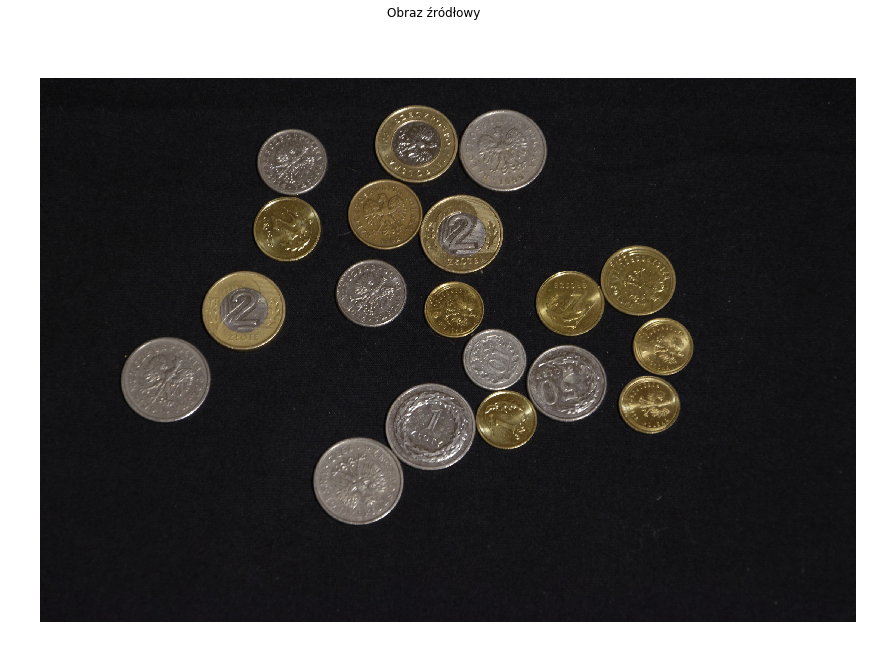

C:\Users\Machina\Anaconda3\envs\py36\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


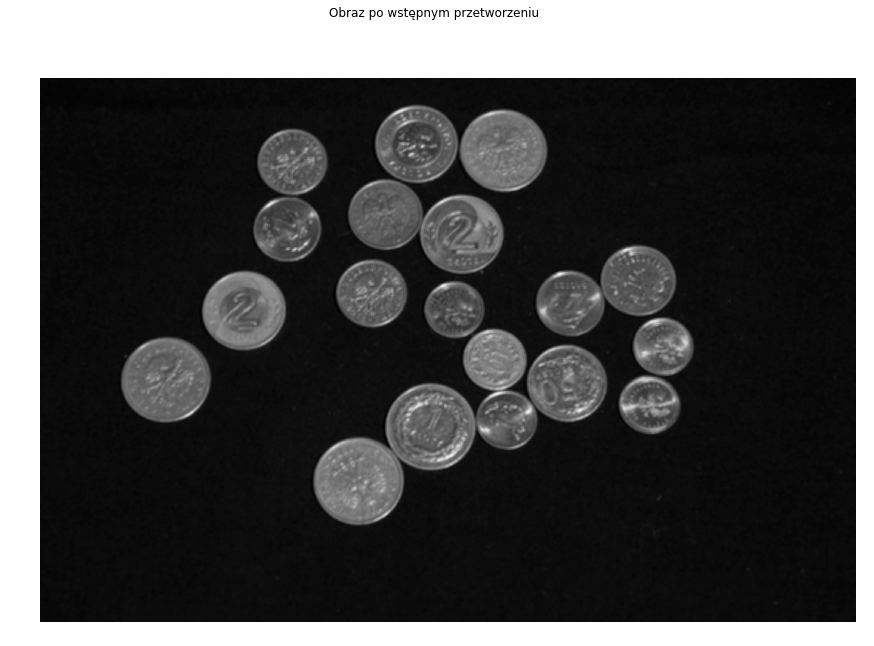

In [4]:
sourceimg = io.imread("source.jpg")

showimg(sourceimg, title="Obraz źródłowy")

processedimg = sourceimg.copy()
processedimg = img_as_ubyte(rgb2gray(processedimg))
processedimg = cv2.blur(processedimg, (11,11))

bwblurredimg = processedimg.copy()

showimg(bwblurredimg, title="Obraz po wstępnym przetworzeniu")

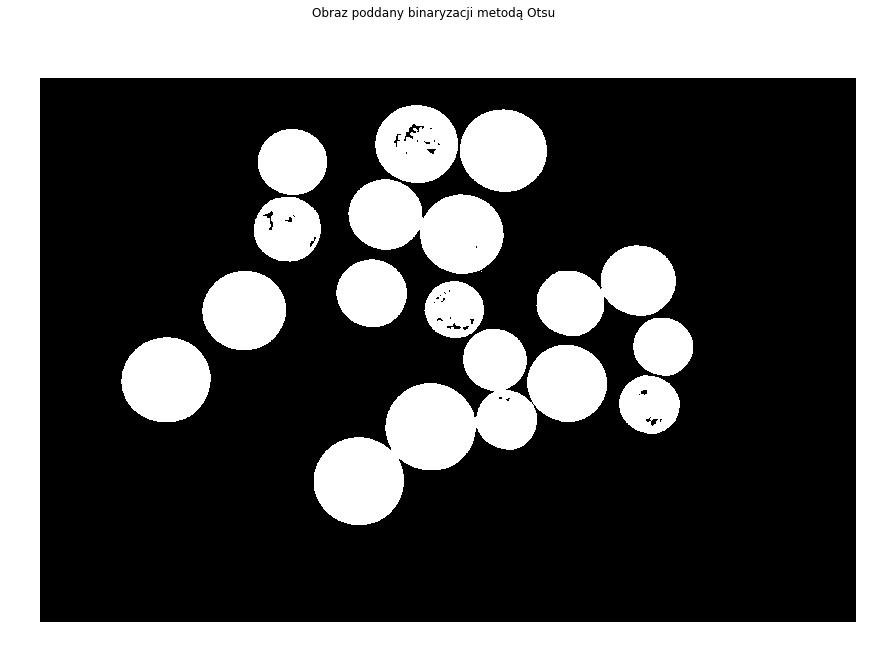

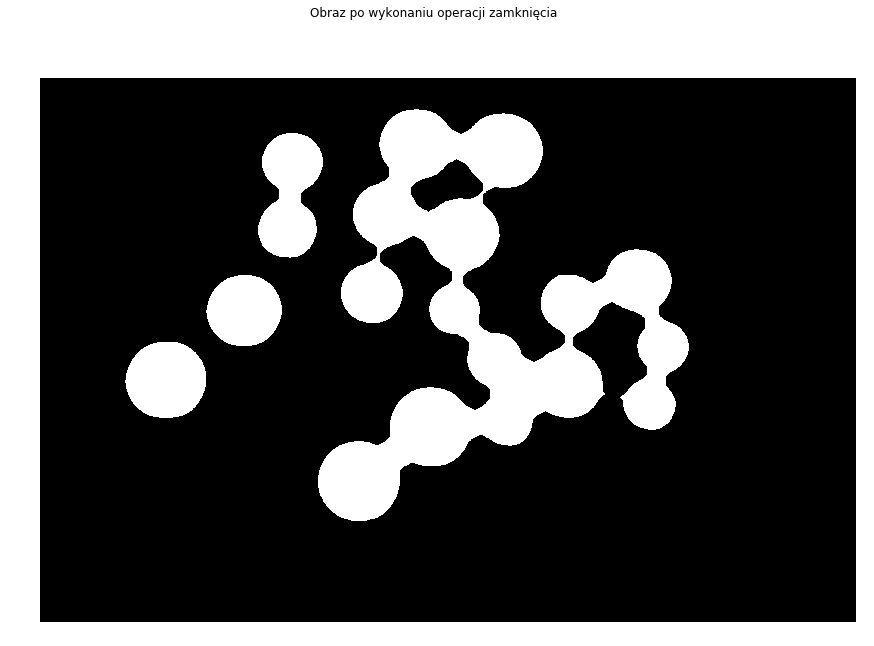

In [12]:
th = 128
th, bim = cv2.threshold(bwblurredimg, thresh=th, maxval=255, type=cv2.THRESH_OTSU)
processedimg = bim
showimg(processedimg, title="Obraz poddany binaryzacji metodą Otsu")

morphKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_CLOSE, kernel=morphKernel, iterations=10)
processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_ERODE, kernel=morphKernel, iterations=5)

binaryimg = processedimg.copy()

showimg(processedimg, title="Obraz po wykonaniu operacji zamknięcia")


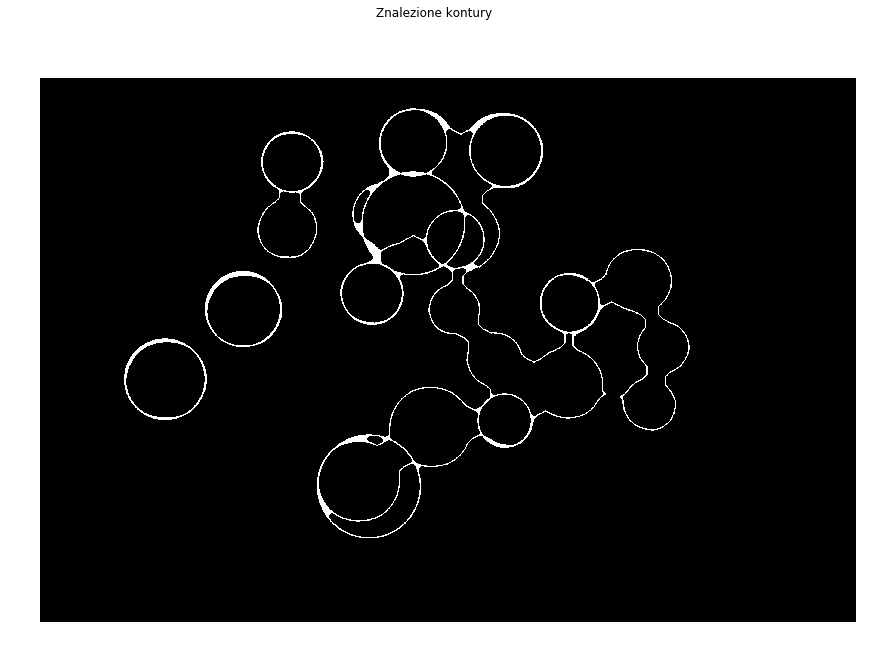

In [13]:
_, contours, hierarchy = cv2.findContours(binaryimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contoursimg = np.zeros_like(binaryimg)
cv2.drawContours(contoursimg, contours, -1, (255,255,255), 3)
circles = cv2.HoughCircles(contoursimg, cv2.HOUGH_GRADIENT, 1, 100, param1=210, param2=45)[0]
# print(circles)
for i in range(len(circles)):
    mycircle = circles[i]
    cv2.circle(contoursimg, (mycircle[0], mycircle[1]), mycircle[2], (255,255,255), 3)
contoursimg = cv2.morphologyEx(contoursimg, op=cv2.MORPH_CLOSE, kernel=morphKernel, iterations=4)
showimg(contoursimg, title="Znalezione kontury")

In [7]:
separated_img = cv2.bitwise_and(binaryimg, cv2.bitwise_not(contoursimg))

Liczba obiektów: 27
Segmentacja ukończona w 25.703 sekund
{0: 5094740, 1: 48977, 2: 62993, 3: 39447, 4: 2287, 5: 9934, 6: 48716, 7: 37070, 8: 5878, 9: 30509, 10: 13330, 11: 500, 12: 49464, 13: 8232, 14: 31868, 15: 33203, 16: 58613, 17: 19926, 18: 1801, 19: 62784, 20: 1780, 21: 16523, 22: 66613, 23: 57609, 24: 19376, 25: 90603, 26: 36233, 27: 50991}


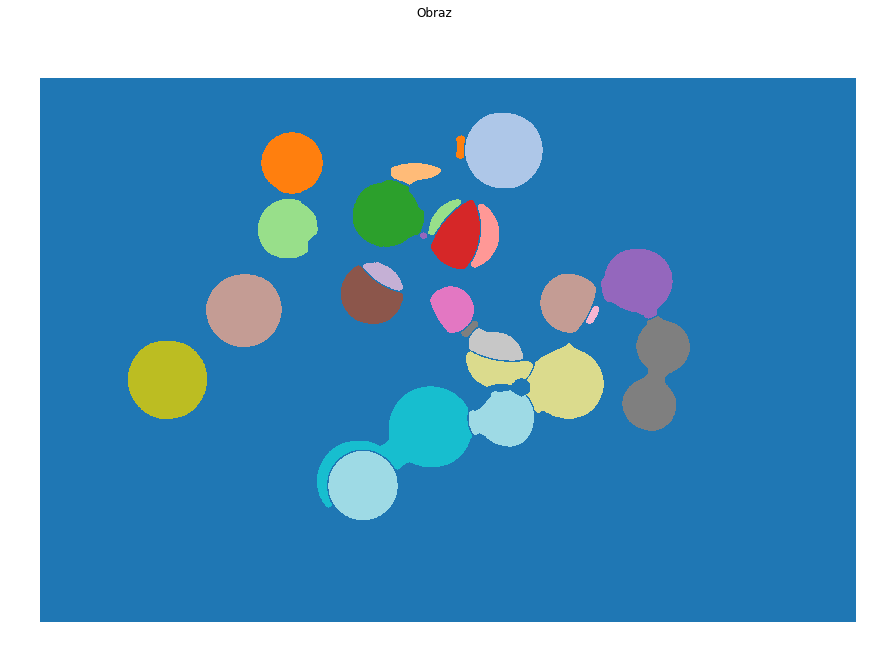

In [8]:
time_now = time.time()
obj_count, segment_table = segment(cv2.bitwise_not(separated_img))
time_delta = time.time() - time_now
print("Liczba obiektów: %d" % obj_count)
print("Segmentacja ukończona w %.3f sekund" % time_delta)
unique_elements, counts_elements = np.unique(segment_table, return_counts=True)
print(dict(zip(unique_elements, counts_elements)))
showimg(segment_table, cmap="tab20")